# Custom kernel implementation

In [1]:
import numpy as np
from scipy.spatial.distance import cdist
import pandas as pd
from sklearn.datasets import load_iris
from sklearn import svm
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [2]:
# load toy dataset, 2 classes (50 samples each), 2 features
data = load_iris()
X = data.data
Y = data.target
X = data.data[Y != 0, :2]
Y = data.target[Y != 0]


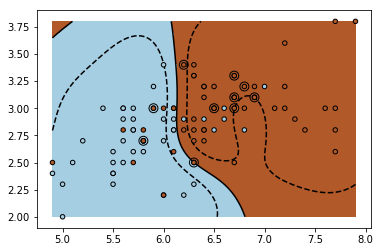

In [3]:
# Basic SVM example
n_sample = len(X)

# uncomment to make random order
#order = np.random.permutation(n_sample)
#X = X[order]
#Y = Y[order].astype(np.float)

X_train = X[:int(.9 * n_sample)]
Y_train = Y[:int(.9 * n_sample)]
X_test = X[int(.9 * n_sample):]
Y_test = Y[int(.9 * n_sample):]

clf = svm.SVC(kernel="rbf", gamma=4); # linear, rbf, poly
clf.fit(X_train, Y_train);

# plot
plt.figure()
plt.clf()
plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired, edgecolor='k', s=20)
plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none', zorder=10, edgecolor='k')

x_min = X[:, 0].min()
x_max = X[:, 0].max()
y_min = X[:, 1].min()
y_max = X[:, 1].max()

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

plt.show()


## 2.2 random walk kernel and 2.3 kernel induced by a clustered representation

In [4]:
def rbf_kernel(X, sigma, diag=0):
    N = X.shape[0]
    K = np.zeros((N,N))

    for i in range(N):
        for j in range(N):
            if i == j:
                K[i,j] = diag
            else:
                x_i = X[i, :].reshape(1,-1)
                x_j = X[j, :].reshape(1,-1)

                K[i, j] = np.exp(-cdist(x_i, x_j, 'sqeuclidean') / (sigma ** 2)) # euclidean?
    return K


def make_D_matrix(K):
    K_sum = np.sum(K, axis=1)
    D = np.diag(K_sum)

    return D


def make_L_matrix(K, D):
    D_temp = np.diag( np.diag(D) ** -0.5 )
    L = D_temp @ K @ D_temp
    
    w, v = LA.eig(L) # w = eigenvalues, v = normalized (unit “length”) eigenvectors
    
    print("w: {}".format(w))
    print("v: {}".format(v))
    
    return L

def step_transfer(L, lambda_cut):
    w, v = LA.eig(L) # w = eigenvalues
    return np.where(w > lambda_cut, 1, 0)

def apply_transfer_func(L, D, K, type="linear"):
    if type == "linear":
        return L, D, K
    if type == "step":
        None
        
    L_hat = 0
    D_hat = 0
    K_hat = 0
    
    return L_hat, D_hat, K_hat


def test_run(X):
    X = X[:4, :] # "testing with a small X"
    
    K = rbf_kernel(X, 1)
    D = make_D_matrix(K)
    L = make_L_matrix(K, D)
    
    L, D, K = apply_transfer_func(L, D, K)
    
    print(K, "\n\n", D, "\n\n", L)    



test_run(X)   

w: [ 1.          0.00887591 -0.55451949 -0.45435642]
v: [[ 0.55817154  0.31595353 -0.67026813  0.37330755]
 [ 0.54868384 -0.19288126 -0.08461    -0.80906366]
 [ 0.5742444   0.25109484  0.73718917  0.25248144]
 [ 0.24007071 -0.89438335 -0.01157167  0.37724075]]
[[ 0.          0.69767633  0.98019867  0.0468877 ]
 [ 0.69767633  0.          0.77105159  0.1978987 ]
 [ 0.98019867  0.77105159  0.          0.07427358]
 [ 0.0468877   0.1978987   0.07427358  0.        ]] 

 [[ 1.72476269  0.          0.          0.        ]
 [ 0.          1.66662661  0.          0.        ]
 [ 0.          0.          1.82552384  0.        ]
 [ 0.          0.          0.          0.31905997]] 

 [[ 0.          0.4115003   0.55240256  0.06320596]
 [ 0.4115003   0.          0.44204911  0.27138611]
 [ 0.55240256  0.44204911  0.          0.09732052]
 [ 0.06320596  0.27138611  0.09732052  0.        ]]


In [43]:
# Do transformation according to all data points
# Sort out only the labeled points and use them to train a linear SVM

    
        
        
def transformation(X):
    
    K = rbf_kernel(X, 1)
    D = make_D_matrix(K)
    L = make_L_matrix(K, D)
    
    L, D, K = apply_transfer_func(L, D, K)
    w, v = LA.eig(L)
    
    return v



# Basic SVM example
n_sample = len(X)

# uncomment to make random order
#order = np.random.permutation(n_sample)
#X = X[order]
#Y = Y[order].astype(np.float)

X_train = X[:int(.9 * n_sample)]
Y_train = Y[:int(.9 * n_sample)]
X_test = X[int(.9 * n_sample):]
Y_test = Y[int(.9 * n_sample):]

V = transformation(X)
V_train = V[:int(.9 * n_sample)]
print(V_train.shape)

'''
print("V {}".format(V.shape))
print("V_train {}".format(V_train.shape))
print("X_train {}".format(X_train.shape))
print("Y_train {}".format(Y_train.shape))


clf = svm.SVC(kernel="linear", gamma=4); # linear, rbf, poly
clf.fit(V_train, Y_train);


# plot
plt.figure()
plt.clf()
plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired, edgecolor='k', s=20)
plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none', zorder=10, edgecolor='k')

x_min = X[:, 0].min()
x_max = X[:, 0].max()
y_min = X[:, 1].min()
y_max = X[:, 1].max()

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-.5, 0, .5])
'''
plt.show()

w: [ 1.          0.47058188  0.22218926  0.09399028  0.08425855 -0.09070778
  0.0533579  -0.05227871 -0.0473407   0.00657809 -0.04453643 -0.04196047
 -0.04272977  0.0021178  -0.03860346 -0.03440936 -0.03229759 -0.03209501
 -0.02851815 -0.00732367 -0.02589384 -0.02594549 -0.02467797 -0.02372075
 -0.02263132 -0.02220576 -0.02192045 -0.02140053 -0.02126973 -0.02264521
 -0.02084828 -0.02210184 -0.02033299 -0.02025938 -0.02022828 -0.01948788
 -0.01944689 -0.01499466 -0.01503796 -0.01509677 -0.01878689 -0.01891473
 -0.01900611 -0.01911349 -0.01864417 -0.01512931 -0.01924508 -0.01857589
 -0.0151417  -0.01830432 -0.01824119 -0.0152163  -0.01524521 -0.01537042
 -0.0154031  -0.01801799 -0.01795178 -0.0155257  -0.01560267 -0.01562535
 -0.01568139 -0.01776291 -0.01605492 -0.01599089 -0.0162494  -0.01764245
 -0.01762184 -0.01639923 -0.01587163 -0.01588891 -0.01759231 -0.01922408
 -0.01706188 -0.01584572 -0.01919842 -0.0171408  -0.01682908 -0.0172983
 -0.0167491  -0.01651705 -0.0197956  -0.01745883 

(100, 2)
[[ 7.   3.2]
 [ 6.4  3.2]
 [ 6.9  3.1]
 [ 5.5  2.3]
 [ 6.5  2.8]
 [ 5.7  2.8]
 [ 6.3  3.3]
 [ 4.9  2.4]
 [ 6.6  2.9]
 [ 5.2  2.7]
 [ 5.   2. ]
 [ 5.9  3. ]
 [ 6.   2.2]
 [ 6.1  2.9]
 [ 5.6  2.9]
 [ 6.7  3.1]
 [ 5.6  3. ]
 [ 5.8  2.7]
 [ 6.2  2.2]
 [ 5.6  2.5]
 [ 5.9  3.2]
 [ 6.1  2.8]
 [ 6.3  2.5]
 [ 6.1  2.8]
 [ 6.4  2.9]
 [ 6.6  3. ]
 [ 6.8  2.8]
 [ 6.7  3. ]
 [ 6.   2.9]
 [ 5.7  2.6]
 [ 5.5  2.4]
 [ 5.5  2.4]
 [ 5.8  2.7]
 [ 6.   2.7]
 [ 5.4  3. ]
 [ 6.   3.4]
 [ 6.7  3.1]
 [ 6.3  2.3]
 [ 5.6  3. ]
 [ 5.5  2.5]
 [ 5.5  2.6]
 [ 6.1  3. ]
 [ 5.8  2.6]
 [ 5.   2.3]
 [ 5.6  2.7]
 [ 5.7  3. ]
 [ 5.7  2.9]
 [ 6.2  2.9]
 [ 5.1  2.5]
 [ 5.7  2.8]
 [ 6.3  3.3]
 [ 5.8  2.7]
 [ 7.1  3. ]
 [ 6.3  2.9]
 [ 6.5  3. ]
 [ 7.6  3. ]
 [ 4.9  2.5]
 [ 7.3  2.9]
 [ 6.7  2.5]
 [ 7.2  3.6]
 [ 6.5  3.2]
 [ 6.4  2.7]
 [ 6.8  3. ]
 [ 5.7  2.5]
 [ 5.8  2.8]
 [ 6.4  3.2]
 [ 6.5  3. ]
 [ 7.7  3.8]
 [ 7.7  2.6]
 [ 6.   2.2]
 [ 6.9  3.2]
 [ 5.6  2.8]
 [ 7.7  2.8]
 [ 6.3  2.7]
 [ 6.7  3.3]
 [ 7.2  3.2]
 [ 